# Using Bayesian and Grad policy approach to get most possible rewards from bandit machines  
from https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl

In [67]:
%matplotlib inline
%config Completer.use_jedi = False
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

In [24]:
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.1,0.5,0.6]

## Bayesian implementation

In [41]:
class BanditBernoulli(object):
    '''
    class to simulate a bandit with given probability
    '''
    def __init__(self, p):
        '''
        Input: p - true probability for a bandit
        Also sets the following properties:
        N - number of trials run so far
        a, b - params of Beta distribution set to 1 and 1 for uniform
        '''
        self.p = p
        self.a , self.b = 1, 1
        self.N = 0
        
    def pull(self):
        # get a real value from bandit
        return np.random.random() <= self.p

    def get_pdf(self,x):
        return beta.pdf(x,self.a,self.b)

    def sample(self):
        # Get an estimation of p from Beta distribution
        return beta.rvs(self.a, self.b)
    
    def update(self, x):
        #update a and b after a bandit pull
        self.N += 1
        self.a += x
        self.b += 1 - x

In [42]:
def plot(bandits, trial):
    # plot all bandit distributions on the graph
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = b.get_pdf(x)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()

In [74]:
def experiment(class_name, plot_graphs=False):
    # class_name - what class to create
    bandits = [class_name(p) for p in BANDIT_PROBABILITIES] # instantiate bandits

    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    
    rewards = np.zeros(NUM_TRIALS)
    
    for i in range(NUM_TRIALS):
        # Thompson sampling - take the bandit with the highest prob to win
        j = np.argmax([b.sample() for b in bandits])

        # plot the posteriors
        if (i in sample_points)and(plot_graphs):
            plot(bandits, i)

        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

        # update rewards
        rewards[i] = x

        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])
    return rewards.sum()

In [60]:
# run experiment 50 times
bayes_reward = np.array([experiment(BanditBernoulli) for k in range(50)])

total reward earned: 1166.0
overall win rate: 0.583
num times selected each bandit: [10, 133, 1857]
total reward earned: 1199.0
overall win rate: 0.5995
num times selected each bandit: [8, 85, 1907]
total reward earned: 1220.0
overall win rate: 0.61
num times selected each bandit: [12, 31, 1957]
total reward earned: 1181.0
overall win rate: 0.5905
num times selected each bandit: [9, 72, 1919]
total reward earned: 1190.0
overall win rate: 0.595
num times selected each bandit: [7, 352, 1641]
total reward earned: 1196.0
overall win rate: 0.598
num times selected each bandit: [19, 69, 1912]
total reward earned: 1187.0
overall win rate: 0.5935
num times selected each bandit: [8, 10, 1982]
total reward earned: 1205.0
overall win rate: 0.6025
num times selected each bandit: [9, 82, 1909]
total reward earned: 1171.0
overall win rate: 0.5855
num times selected each bandit: [7, 489, 1504]
total reward earned: 1219.0
overall win rate: 0.6095
num times selected each bandit: [7, 57, 1936]
total rew

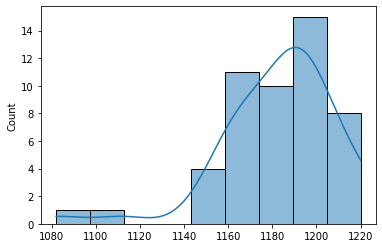

In [72]:
sns.histplot(bayes_reward, kde=True);

##  Grad policy updater implementation

In [329]:
class GradBandit(object):
    # class to model a bandit with Grad Uphill Algorythm
    def __init__(self, p, alpha=0.1):
        self.p = p
        self.N = 0 # how many times the bandit was used
        self.H = 0 # H - the preference towards this bandit
        self.alpha = alpha # learning rate for the update of preference H
        
    def pull(self):
        # get a real value from bandit
        self.N += 1
        return np.random.random() <= self.p

    def update(self, delta):
        # update a preference
        self.H += self.alpha*delta

In [331]:
class GradBanditUpdater(object):
    def __init__(self, grad_bandits):
        self.grad_bandits = grad_bandits # list with bandits
        self.NB = len(grad_bandits) # number of bandits 
        self.probs = [1/len(self.grad_bandits)]*self.NB # initial probs to select bandits
        self.reward = 0 # cumulative reward for updater
        self.running_n = 0 # number pull iterations
    def update_probs(self):
        # apply softmax to bandits and update probs for updater
        softmax_denominator = np.sum([np.exp(b.H) for b in self.grad_bandits])
        for i,b in enumerate(self.grad_bandits):
            self.probs[i] = np.exp(b.H)/softmax_denominator
    def get_pull_bandit(self):
        # select a bandit to pull from 
        return np.random.choice(list(range(self.NB)),1,p=self.probs)[0]
    def pull_bandit(self, i):
        # actuall pull a bandit number i from the self.grad_bandits
        self.running_n +=1
        return np.random.random() <= self.grad_bandits[i].p
    def make_iteration(self):
        # main routine - makes a selection and updates all data
        # make a selection of bandit
        selected_bandit = self.get_pull_bandit()
        # pull a bandit
        iteration_reward = self.pull_bandit(selected_bandit)
        self.reward += iteration_reward # update reward
        current_mean_reward = self.reward/self.running_n # update mean reward
        # update preference estimation
        for i in range(self.NB):
            if i == selected_bandit:
                delta = (iteration_reward - current_mean_reward)*(1 - self.probs[i])
            else:
                delta = -(iteration_reward - current_mean_reward)*self.probs[i]
            self.grad_bandits[i].update(delta)
        # update probs via softmax
        self.update_probs()
        # and we are done
        return self.reward

In [332]:
grad_bandits = [GradBandit(p) for p in BANDIT_PROBABILITIES]
gb_updater = GradBanditUpdater(grad_bandits)

In [333]:
def experiment_grad_bandits():
    grad_bandits = [GradBandit(p) for p in BANDIT_PROBABILITIES]
    gb_updater = GradBanditUpdater(grad_bandits)
    trial_results =[]
    for i in range(NUM_TRIALS):
        trial_results.append(gb_updater.make_iteration())
    return gb_updater, trial_results

In [ ]:
# run 50 experiments
gb_rewards = []
for i in tqdm(range(50)):
    gb_updater, trial_results = experiment_grad_bandits()
    gb_rewards.append(gb_updater.reward)

## Compare results

In [350]:
import scipy.stats as st

In [361]:
# they are different
st.ttest_ind(bayes_reward, gb_rewards)

Ttest_indResult(statistic=6.987149486641803, pvalue=3.4162541586138974e-10)

In [363]:
gb_reward_interval = st.t.interval(alpha=0.95, df=len(gb_rewards)-1, loc=np.mean(gb_rewards), scale=st.sem(gb_rewards))
bayes_reward_interval =  st.t.interval(alpha=0.95, df=len(bayes_reward)-1, loc=np.mean(bayes_reward), scale=st.sem(bayes_reward)) 

print(f"{gb_reward_interval[0]:.0f} - {gb_reward_interval[1]:.0f} Grad policy updater ")
print(f"{bayes_reward_interval[0]:.0f} - {bayes_reward_interval[1]:.0f} Bayesian updater")

1145 - 1156 Grad policy updater 
1175 - 1190 Bayesian updater


In [ ]:
(np.mean(bayes_reward)-np.mean(gb_rewards))/np.mean(gb_rewards)

## Debug zone

In [303]:
gb_updater.probs

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [323]:
gb_updater.make_iteration()

6

In [296]:
gb_updater.get_pull_bandit()

2

In [297]:
grad_bandits[0].H = 110 

In [298]:
grad_bandits[2].H = 120

In [299]:
gb_updater.update_probs()

In [324]:
gb_updater.probs

[0.26892959203422073, 0.3796829301340696, 0.3513874778317097]

In [214]:
gb_updater.grad_bandits[0].H

10